In [111]:
from project.thermal import conventional_heating_final, stat_heating_consumption, HDD, conventional_energy_3uses ,VENTILATION_TYPES
from project.utils import make_plot
from project.input.param import generic_input
import pandas as pd
import math

# Estimation of EPC and energy need

In [112]:
buildings = pd.read_csv('building_stock_profeel_detailed.csv', index_col=['Class', 'Housing type'])
buildings = buildings[buildings['Heating system'] != 'RCU']
ratio_surface = buildings.loc[:,'Ratio_surface_Wall':'Ratio_surface_Window']
ratio_surface = ratio_surface.rename(columns={'Ratio_surface_Floor': "Floor", 'Ratio_surface_Wall': "Wall", 'Ratio_surface_Roof': "Roof", 'Ratio_surface_Window': "Windows"})

In [113]:
'''efficiency = pd.read_csv('project/input/efficiency.csv')
efficiency = to_dict(efficiency)'''

"efficiency = pd.read_csv('project/input/efficiency.csv')\nefficiency = to_dict(efficiency)"

In [114]:
efficiency = {'Electricity-Performance boiler': 0.95,
           'Natural gas-Standard boiler': 0.6,
          'Natural gas-Performance boiler': 0.76,
              'Wood fuel-Standard boiler': 0.6
           }


heating_eff = buildings['Heating system'].replace(efficiency).set_axis(buildings.index)
buildings = pd.concat((buildings, heating_eff.rename('Efficiency')), axis=1)
buildings

,,Wall,Floor,Roof,Windows,Heating system,Stock buildings,Ratio_surface_Wall,Ratio_surface_Floor,Ratio_surface_Roof,Ratio_surface_Window,construction period,EPC,primary energy,Ventilation gross,Ventilation,Electric fuel share,Fossil fuel share,Efficiency
Class,Housing type,,,,,,,,,,,,,,,,,,
MI-1,Single-family,2.50,2.00,2.50,2.4,Wood fuel-Standard boiler,688400,1.76,0.50,0.50,0.15,Avant 1915,E,311,Ouverture des baies,Natural ventilation,0.18,0.82,0.60
MI-2,Single-family,2.50,2.00,2.50,2.4,Wood fuel-Standard boiler,648300,1.33,0.50,0.85,0.13,Avant 1915,F,339,Ouverture des baies,Natural ventilation,0.15,0.85,0.60
MI-3,Single-family,2.50,2.00,2.50,2.4,Wood fuel-Standard boiler,622300,0.87,0.89,1.61,0.09,Avant 1915,F,339,Ouverture des baies,Natural ventilation,0.20,0.80,0.60
MI-4,Single-family,2.50,2.00,2.50,2.4,Wood fuel-Standard boiler,3186600,1.25,0.67,0.67,0.13,Avant 1915,E,283,Ouverture des baies,Natural ventilation,0.23,0.77,0.60
MI-5,Single-family,2.50,2.00,2.50,2.4,Natural gas-Standard boiler,612000,1.45,0.51,0.80,0.18,1915-1945,E,313,Ouverture des baies,Natural ventilation,0.20,0.80,0.60
MI-6,Single-family,2.50,2.00,2.50,2.4,Natural gas-Standard boiler,86300,1.06,0.35,0.55,0.24,1915-1945,F,350,Ouverture des baies,Natural ventilation,0.19,0.81,0.60
MI-7,Single-family,2.50,2.00,2.50,2.4,Natural gas-Standard boiler,741300,1.02,0.50,0.50,0.15,1915-1945,E,313,Ouverture des baies,Natural ventilation,0.21,0.79,0.60
MI-8,Single-family,2.50,2.00,2.50,2.4,Natural gas-Standard boiler,1364000,1.55,0.55,0.55,0.21,1946-1968,E,293,Ouverture des baies,Natural ventilation,0.16,0.84,0.60
MI-9,Single-family,2.50,2.00,2.50,2.4,Natural gas-Standard boiler,923400,1.22,0.50,0.50,0.20,1946-1968,E,267,Ouverture des baies,Natural ventilation,0.11,0.89,0.60


In [115]:
translate = {'Natural ventilation': 'Ventilation naturelle', 'CMV': 'VMC SF auto et VMC double flux',
                     'CMV hygro': 'VMC SF hydrogérable'}

buildings['Ventilation'] = buildings['Ventilation'].replace(translate)
buildings['Ventilation'] = buildings['Ventilation'].replace(VENTILATION_TYPES)


In [116]:
conventional_heating_final(buildings['Wall'], buildings['Floor'], buildings['Roof'], buildings['Windows'], ratio_surface, buildings['Efficiency'])

Class  Housing type 
MI-1   Single-family    543.096229
MI-2   Single-family    524.206233
MI-3   Single-family    615.586544
MI-4   Single-family    484.211094
MI-5   Single-family    545.120274
MI-6   Single-family    404.712123
MI-7   Single-family    388.491595
MI-8   Single-family    520.462310
MI-9   Single-family    435.804522
MI-10  Single-family    583.250820
MI-11  Single-family    338.532247
MI-12  Single-family    149.893476
MI-13  Single-family    173.627260
MI-14  Single-family    116.936507
MI-15  Single-family     92.657724
MI-16  Single-family    117.672179
MI-17  Single-family     78.857016
LC1    Multi-family     122.435851
LC2    Multi-family     109.553944
LC3    Multi-family     207.775433
LC4    Multi-family     192.921960
LC5    Multi-family     156.210845
LC6    Multi-family     157.006354
LC7    Multi-family     218.284814
LC8    Multi-family     170.668903
LC9    Multi-family     243.902313
LC10   Multi-family     333.287609
LC11   Multi-family     274.248369

In [117]:
stat_heating_consumption(buildings['Wall'], buildings['Floor'], buildings['Roof'], buildings['Windows'], buildings['Efficiency'], ratio_surface, HDD)

Class  Housing type 
MI-1   Single-family    688.904416
MI-2   Single-family    664.688494
MI-3   Single-family    766.153931
MI-4   Single-family    617.601242
MI-5   Single-family    694.459819
MI-6   Single-family    535.333797
MI-7   Single-family    506.276081
MI-8   Single-family    668.794806
MI-9   Single-family    568.024862
MI-10  Single-family    736.346141
MI-11  Single-family    448.226415
MI-12  Single-family    200.718399
MI-13  Single-family    237.475529
MI-14  Single-family    152.076934
MI-15  Single-family    118.537762
MI-16  Single-family    156.667911
MI-17  Single-family    105.848773
LC1    Multi-family     175.191995
LC2    Multi-family     158.161535
LC3    Multi-family     288.503058
LC4    Multi-family     272.651496
LC5    Multi-family     229.353904
LC6    Multi-family     221.518599
LC7    Multi-family     307.354997
LC8    Multi-family     241.423590
LC9    Multi-family     334.724891
LC10   Multi-family     480.796276
LC11   Multi-family     402.507047

##### Comparing the surface ratio of Profeel's database with the aggregated ones in Res-IRF

In [118]:
temp = pd.concat((buildings['Stock buildings'], ratio_surface), axis=1)
av_ratio_surface = (temp['Stock buildings'] * temp.loc[:, 'Wall':].T).T
av_ratio_surface = ((av_ratio_surface.groupby('Housing type').sum()).T/temp.groupby('Housing type')['Stock buildings'].sum()).T.sort_index(ascending=False)
av_ratio_surface

,Wall,Floor,Roof,Windows
Housing type,,,,
Single-family,1.167578,0.350053,1.057829,0.183813
Multi-family,0.496068,0.067430,0.163829,0.306495


In [119]:
agg_ratio_surface = generic_input['ratio_surface']
agg_ratio_surface

,Wall,Floor,Roof,Windows
Housing type,,,,
Single-family,1.42,0.1875,0.77,0.17
Multi-family,0.78,0.0700,0.29,0.19


## Calculating EPC and annual energy need

Taking the aggregate surface ratio used in Res-IRF

In [120]:
buildings = buildings.set_index('Heating system', append=True)
epc, energy_primary = conventional_energy_3uses(buildings['Wall'], buildings['Floor'], buildings['Roof'], buildings['Windows'], agg_ratio_surface, buildings['Efficiency'], buildings.index, air_rate=buildings['Ventilation'])
energy_epc_surface = pd.concat((buildings, epc.rename('calculated_epc'), energy_primary.rename('primary_energy_estimated')), axis=1)
energy_epc_surface

,,,Wall,Floor,Roof,Windows,Stock buildings,Ratio_surface_Wall,Ratio_surface_Floor,Ratio_surface_Roof,Ratio_surface_Window,construction period,EPC,primary energy,Ventilation gross,Ventilation,Electric fuel share,Fossil fuel share,Efficiency,calculated_epc,primary_energy_estimated
Class,Housing type,Heating system,,,,,,,,,,,,,,,,,,,
MI-1,Single-family,Wood fuel-Standard boiler,2.50,2.00,2.50,2.4,688400,1.76,0.50,0.50,0.15,Avant 1915,E,311,Ouverture des baies,0.4,0.18,0.82,0.60,G,516.121789
MI-2,Single-family,Wood fuel-Standard boiler,2.50,2.00,2.50,2.4,648300,1.33,0.50,0.85,0.13,Avant 1915,F,339,Ouverture des baies,0.4,0.15,0.85,0.60,G,516.121789
MI-3,Single-family,Wood fuel-Standard boiler,2.50,2.00,2.50,2.4,622300,0.87,0.89,1.61,0.09,Avant 1915,F,339,Ouverture des baies,0.4,0.20,0.80,0.60,G,516.121789
MI-4,Single-family,Wood fuel-Standard boiler,2.50,2.00,2.50,2.4,3186600,1.25,0.67,0.67,0.13,Avant 1915,E,283,Ouverture des baies,0.4,0.23,0.77,0.60,G,516.121789
MI-5,Single-family,Natural gas-Standard boiler,2.50,2.00,2.50,2.4,612000,1.45,0.51,0.80,0.18,1915-1945,E,313,Ouverture des baies,0.4,0.20,0.80,0.60,G,516.121789
MI-6,Single-family,Natural gas-Standard boiler,2.50,2.00,2.50,2.4,86300,1.06,0.35,0.55,0.24,1915-1945,F,350,Ouverture des baies,0.4,0.19,0.81,0.60,G,516.121789
MI-7,Single-family,Natural gas-Standard boiler,2.50,2.00,2.50,2.4,741300,1.02,0.50,0.50,0.15,1915-1945,E,313,Ouverture des baies,0.4,0.21,0.79,0.60,G,516.121789
MI-8,Single-family,Natural gas-Standard boiler,2.50,2.00,2.50,2.4,1364000,1.55,0.55,0.55,0.21,1946-1968,E,293,Ouverture des baies,0.4,0.16,0.84,0.60,G,516.121789
MI-9,Single-family,Natural gas-Standard boiler,2.50,2.00,2.50,2.4,923400,1.22,0.50,0.50,0.20,1946-1968,E,267,Ouverture des baies,0.4,0.11,0.89,0.60,G,516.121789


Without taking ventilation into account

In [121]:
epc, energy_primary = conventional_energy_3uses(buildings['Wall'], buildings['Floor'], buildings['Roof'], buildings['Windows'], ratio_surface, buildings['Efficiency'], buildings.index)
energy_epc_novent = pd.concat((buildings, epc.rename('calculated_epc'), energy_primary.rename('primary_energy_estimated')), axis=1)
buildings['primary_energy_estimated'] = energy_primary
buildings['estimation_error'] = buildings['primary_energy_estimated'] - buildings['primary energy']
energy_epc_novent

,,,Wall,Floor,Roof,Windows,Stock buildings,Ratio_surface_Wall,Ratio_surface_Floor,Ratio_surface_Roof,Ratio_surface_Window,construction period,EPC,primary energy,Ventilation gross,Ventilation,Electric fuel share,Fossil fuel share,Efficiency,calculated_epc,primary_energy_estimated
Class,Housing type,Heating system,,,,,,,,,,,,,,,,,,,
MI-1,Single-family,Wood fuel-Standard boiler,2.50,2.00,2.50,2.4,688400,1.76,0.50,0.50,0.15,Avant 1915,E,311,Ouverture des baies,0.4,0.18,0.82,0.60,G,547.496148
MI-2,Single-family,Wood fuel-Standard boiler,2.50,2.00,2.50,2.4,648300,1.33,0.50,0.85,0.13,Avant 1915,F,339,Ouverture des baies,0.4,0.15,0.85,0.60,G,528.602497
MI-3,Single-family,Wood fuel-Standard boiler,2.50,2.00,2.50,2.4,622300,0.87,0.89,1.61,0.09,Avant 1915,F,339,Ouverture des baies,0.4,0.20,0.80,0.60,G,603.496288
MI-4,Single-family,Wood fuel-Standard boiler,2.50,2.00,2.50,2.4,3186600,1.25,0.67,0.67,0.13,Avant 1915,E,283,Ouverture des baies,0.4,0.23,0.77,0.60,G,481.437033
MI-5,Single-family,Natural gas-Standard boiler,2.50,2.00,2.50,2.4,612000,1.45,0.51,0.80,0.18,1915-1945,E,313,Ouverture des baies,0.4,0.20,0.80,0.60,G,549.106280
MI-6,Single-family,Natural gas-Standard boiler,2.50,2.00,2.50,2.4,86300,1.06,0.35,0.55,0.24,1915-1945,F,350,Ouverture des baies,0.4,0.19,0.81,0.60,F,415.477210
MI-7,Single-family,Natural gas-Standard boiler,2.50,2.00,2.50,2.4,741300,1.02,0.50,0.50,0.15,1915-1945,E,313,Ouverture des baies,0.4,0.21,0.79,0.60,F,392.908546
MI-8,Single-family,Natural gas-Standard boiler,2.50,2.00,2.50,2.4,1364000,1.55,0.55,0.55,0.21,1946-1968,E,293,Ouverture des baies,0.4,0.16,0.84,0.60,G,522.773928
MI-9,Single-family,Natural gas-Standard boiler,2.50,2.00,2.50,2.4,923400,1.22,0.50,0.50,0.20,1946-1968,E,267,Ouverture des baies,0.4,0.11,0.89,0.60,F,440.233061


Taking ventilation into account

In [122]:
epc, energy_primary = conventional_energy_3uses(buildings['Wall'], buildings['Floor'], buildings['Roof'], buildings['Windows'], ratio_surface, buildings['Efficiency'], buildings.index, air_rate=buildings['Ventilation'])
energy_epc_vent = pd.concat((buildings, epc.rename('calculated_epc'), energy_primary.rename('primary_energy_estimated_vent')), axis=1)
energy_epc_vent['vent_estimation_error'] = energy_epc_vent['primary_energy_estimated_vent'] - energy_epc_vent['primary energy']
energy_epc_vent

,,,Wall,Floor,Roof,Windows,Stock buildings,Ratio_surface_Wall,Ratio_surface_Floor,Ratio_surface_Roof,Ratio_surface_Window,construction period,...,Ventilation gross,Ventilation,Electric fuel share,Fossil fuel share,Efficiency,primary_energy_estimated,estimation_error,calculated_epc,primary_energy_estimated_vent,vent_estimation_error
Class,Housing type,Heating system,,,,,,,,,,,,,,,,,,,,,
MI-1,Single-family,Wood fuel-Standard boiler,2.50,2.00,2.50,2.4,688400,1.76,0.50,0.50,0.15,Avant 1915,...,Ouverture des baies,0.4,0.18,0.82,0.60,547.496148,236.496148,G,523.283617,212.283617
MI-2,Single-family,Wood fuel-Standard boiler,2.50,2.00,2.50,2.4,648300,1.33,0.50,0.85,0.13,Avant 1915,...,Ouverture des baies,0.4,0.15,0.85,0.60,528.602497,189.602497,G,504.385586,165.385586
MI-3,Single-family,Wood fuel-Standard boiler,2.50,2.00,2.50,2.4,622300,0.87,0.89,1.61,0.09,Avant 1915,...,Ouverture des baies,0.4,0.20,0.80,0.60,603.496288,264.496288,G,571.027411,232.027411
MI-4,Single-family,Wood fuel-Standard boiler,2.50,2.00,2.50,2.4,3186600,1.25,0.67,0.67,0.13,Avant 1915,...,Ouverture des baies,0.4,0.23,0.77,0.60,481.437033,198.437033,G,453.638665,170.638665
MI-5,Single-family,Natural gas-Standard boiler,2.50,2.00,2.50,2.4,612000,1.45,0.51,0.80,0.18,1915-1945,...,Ouverture des baies,0.4,0.20,0.80,0.60,549.106280,236.106280,G,524.692442,211.692442
MI-6,Single-family,Natural gas-Standard boiler,2.50,2.00,2.50,2.4,86300,1.06,0.35,0.55,0.24,1915-1945,...,Ouverture des baies,0.4,0.19,0.81,0.60,415.477210,65.477210,F,394.481757,44.481757
MI-7,Single-family,Natural gas-Standard boiler,2.50,2.00,2.50,2.4,741300,1.02,0.50,0.50,0.15,1915-1945,...,Ouverture des baies,0.4,0.21,0.79,0.60,392.908546,79.908546,F,368.717101,55.717101
MI-8,Single-family,Natural gas-Standard boiler,2.50,2.00,2.50,2.4,1364000,1.55,0.55,0.55,0.21,1946-1968,...,Ouverture des baies,0.4,0.16,0.84,0.60,522.773928,229.773928,G,497.531662,204.531662
MI-9,Single-family,Natural gas-Standard boiler,2.50,2.00,2.50,2.4,923400,1.22,0.50,0.50,0.20,1946-1968,...,Ouverture des baies,0.4,0.11,0.89,0.60,440.233061,173.233061,F,416.055541,149.055541


#### Annual energy need weighted average wrt. heating energy mix
known parameters:
- surface ratio: we can calculate using the Res-IRF averages
- u values: a large part comes from the French 3CL reference values and the other when reported from profeel
- efficiency: We calculate the weighted average of the annual energy need wrt. electric or fossil fuel share of the heating system
one each fossil fuel has the same efficiency value


In [123]:
stock_main = buildings.copy()
stock_main = stock_main.reset_index('Heating system')
stock_other_carriers = stock_main.replace(to_replace={'Electricity-Performance boiler': 'Natural gas-Standard boiler', 'Natural gas-Standard boiler': 'Electricity-Performance boiler', 'Natural gas-Performance boiler': 'Electricity-Performance boiler', 'Wood fuel-Standard boiler': 'Electricity-Performance boiler'}).copy()

# Creating the weight column which gather the share of the selected energy carrier in the heating system, for the main or the others energy carriers
for idx in stock_main.index:
    if stock_main.loc[idx,'Heating system'] in {'Natural gas-Standard boiler',  'Natural gas-Performance boiler', 'Wood fuel-Standard boiler'}:
        stock_main.loc[idx, 'weights 1'] = stock_main.loc[idx, 'Fossil fuel share']
    else:
        stock_main.loc[idx, 'weights 1'] = stock_main.loc[idx, 'Electric fuel share']

for idx in stock_other_carriers.index:
    if stock_other_carriers.loc[idx,'Heating system'] in {'Natural gas-Standard boiler',  'Natural gas-Performance boiler', 'Wood fuel-Standard boiler'}:
        stock_other_carriers.loc[idx, 'weights 2'] = stock_other_carriers.loc[idx, 'Fossil fuel share']
    else:
        stock_other_carriers.loc[idx, 'weights 2'] = stock_other_carriers.loc[idx, 'Electric fuel share']

# Estimation of annual energy needs for the main energy carrier case
stock_main = stock_main.set_index('Heating system', append=True)
_, stock_main['energy_primary_estimate'] = conventional_energy_3uses(stock_main['Wall'], stock_main['Floor'],
                                                                     stock_main['Roof'], stock_main['Windows'],
                                                                     ratio_surface, stock_main['Efficiency'],
                                                                     stock_main.index)
# applying the weight
stock_main['energy_primary_weighted'] = stock_main['energy_primary_estimate'] * stock_main['weights 1']
stock_main = stock_main.reset_index('Heating system')

# Estimation of annual energy needs for the case of the other energy carrier
heating_eff = stock_other_carriers['Heating system'].replace(efficiency).set_axis(stock_other_carriers.index)
stock_other_carriers['Efficiency'] = heating_eff.rename('Efficiency')
stock_other_carriers = stock_other_carriers.set_index('Heating system', append=True)
_, stock_other_carriers['energy_primary_estimate'] = conventional_energy_3uses(stock_other_carriers['Wall'], stock_other_carriers['Floor'],
                                                                               stock_other_carriers['Roof'], stock_other_carriers['Windows'],
                                                                               ratio_surface, stock_other_carriers['Efficiency'], stock_other_carriers.index)
# Applying the weight
stock_other_carriers['energy_primary_weighted'] = stock_other_carriers['energy_primary_estimate'] * stock_other_carriers['weights 2']
stock_other_carriers = stock_other_carriers.reset_index('Heating system')

In [124]:
buildings['primary_energy_weighted'] = stock_main['energy_primary_weighted'] + stock_other_carriers['energy_primary_weighted']
buildings['weighted_estimation_error'] = buildings['primary_energy_weighted'] - buildings['primary energy']

In [125]:
buildings

,,,Wall,Floor,Roof,Windows,Stock buildings,Ratio_surface_Wall,Ratio_surface_Floor,Ratio_surface_Roof,Ratio_surface_Window,construction period,...,primary energy,Ventilation gross,Ventilation,Electric fuel share,Fossil fuel share,Efficiency,primary_energy_estimated,estimation_error,primary_energy_weighted,weighted_estimation_error
Class,Housing type,Heating system,,,,,,,,,,,,,,,,,,,,,
MI-1,Single-family,Wood fuel-Standard boiler,2.50,2.00,2.50,2.4,688400,1.76,0.50,0.50,0.15,Avant 1915,...,311,Ouverture des baies,0.4,0.18,0.82,0.60,547.496148,236.496148,576.681337,265.681337
MI-2,Single-family,Wood fuel-Standard boiler,2.50,2.00,2.50,2.4,648300,1.33,0.50,0.85,0.13,Avant 1915,...,339,Ouverture des baies,0.4,0.15,0.85,0.60,528.602497,189.602497,549.000267,210.000267
MI-3,Single-family,Wood fuel-Standard boiler,2.50,2.00,2.50,2.4,622300,0.87,0.89,1.61,0.09,Avant 1915,...,339,Ouverture des baies,0.4,0.20,0.80,0.60,603.496288,264.496288,628.667056,289.667056
MI-4,Single-family,Wood fuel-Standard boiler,2.50,2.00,2.50,2.4,3186600,1.25,0.67,0.67,0.13,Avant 1915,...,283,Ouverture des baies,0.4,0.23,0.77,0.60,481.437033,198.437033,510.008683,227.008683
MI-5,Single-family,Natural gas-Standard boiler,2.50,2.00,2.50,2.4,612000,1.45,0.51,0.80,0.18,1915-1945,...,313,Ouverture des baies,0.4,0.20,0.80,0.60,549.106280,236.106280,583.085008,270.085008
MI-6,Single-family,Natural gas-Standard boiler,2.50,2.00,2.50,2.4,86300,1.06,0.35,0.55,0.24,1915-1945,...,350,Ouverture des baies,0.4,0.19,0.81,0.60,415.477210,65.477210,441.213741,91.213741
MI-7,Single-family,Natural gas-Standard boiler,2.50,2.00,2.50,2.4,741300,1.02,0.50,0.50,0.15,1915-1945,...,313,Ouverture des baies,0.4,0.21,0.79,0.60,392.908546,79.908546,414.916863,101.916863
MI-8,Single-family,Natural gas-Standard boiler,2.50,2.00,2.50,2.4,1364000,1.55,0.55,0.55,0.21,1946-1968,...,293,Ouverture des baies,0.4,0.16,0.84,0.60,522.773928,229.773928,543.428556,250.428556
MI-9,Single-family,Natural gas-Standard boiler,2.50,2.00,2.50,2.4,923400,1.22,0.50,0.50,0.20,1946-1968,...,267,Ouverture des baies,0.4,0.11,0.89,0.60,440.233061,173.233061,446.598514,179.598514


In [126]:
# check
#stock_main['weights 1'] + stock_other_carriers['weights 2']

In [127]:
mse_weighted = math.sqrt((buildings['weighted_estimation_error']**2).sum()/buildings.shape[0])
mse_standard = math.sqrt((buildings['estimation_error']**2).sum()/buildings.shape[0])

In [128]:
mse_standard

134.91418721396056

In [129]:
mse_weighted

136.39161404696864

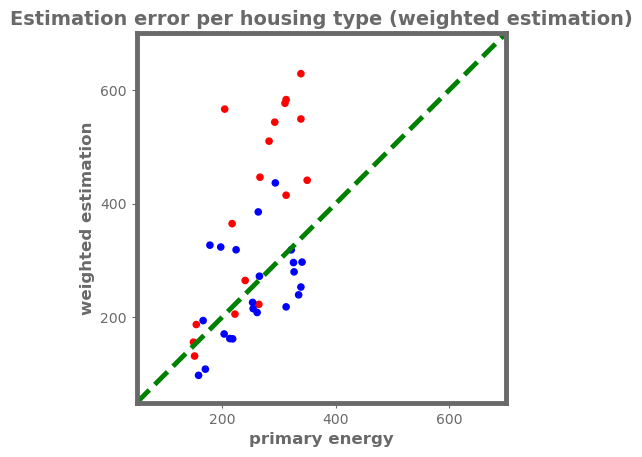

In [130]:
colors = {'Single-family': 'red', 'Multi-family': 'blue'}
scatter = buildings.plot.scatter(x = 'primary energy', y = 'primary_energy_weighted', xlim=(50, 700), ylim=(50,700), c=buildings.index.get_level_values('Housing type').map(colors), fontsize=10)
scatter.set_title('Estimation error per housing type (weighted estimation)', fontsize=14)
scatter.set_xlabel('primary energy', fontsize=12)
scatter.set_ylabel('weighted estimation', fontsize=12)
scatter.axis('scaled')
scatter.set(xlim=(50, 700), ylim=(50,700))
scatter = scatter.plot([0, 1], [0, 1], transform=scatter.transAxes, ls='--',  c='green' )

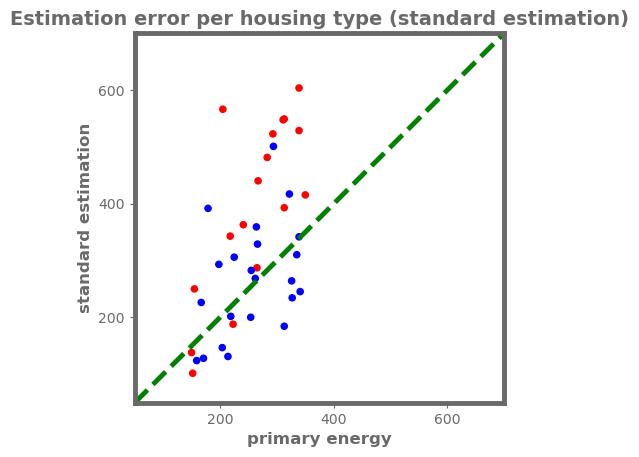

In [131]:
colors = {'Single-family': 'red', 'Multi-family': 'blue'}
scatter = buildings.plot.scatter(x = 'primary energy', y = 'primary_energy_estimated', c=buildings.index.get_level_values('Housing type').map(colors), fontsize=10)
scatter.set_title('Estimation error per housing type (standard estimation)', fontsize=14)
scatter.set_xlabel('primary energy', fontsize=12)
scatter.set_ylabel('standard estimation', fontsize=12)
scatter.axis('scaled')
scatter.set(xlim=(50, 700), ylim=(50,700))
scatter = scatter.plot([0, 1], [0, 1], transform=scatter.transAxes, ls='--',  c='green' )

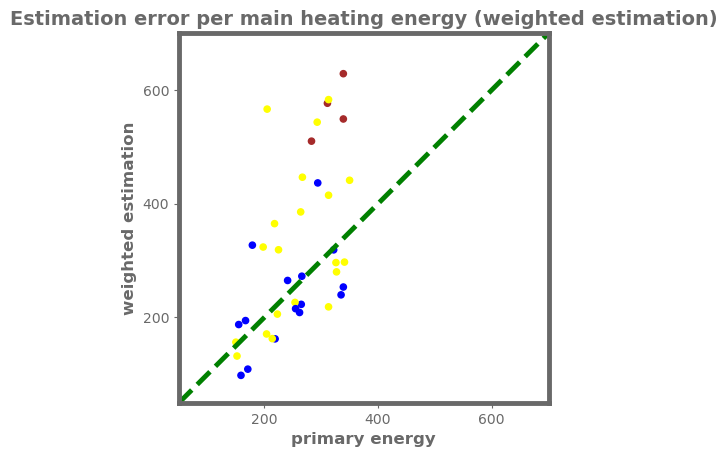

In [108]:
colors = {'Wood fuel-Standard boiler': 'brown', 'Electricity-Performance boiler': 'blue','Natural gas-Standard boiler': 'yellow', 'Natural gas-Performance boiler': 'yellow' }
scatter = buildings.plot.scatter(x = 'primary energy', y = 'primary_energy_weighted', xlim=(50, 700), ylim=(50,700), c=buildings.index.get_level_values('Heating system').map(colors), fontsize=10)
scatter.set_title('Estimation error per main heating energy (weighted estimation)', fontsize=14)
scatter.set_xlabel('primary energy', fontsize=12)
scatter.set_ylabel('weighted estimation', fontsize=12)
scatter.axis('scaled')
scatter.set(xlim=(50, 700), ylim=(50,700))
scatter = scatter.plot([0, 1], [0, 1], transform=scatter.transAxes, ls='--',  c='green' )

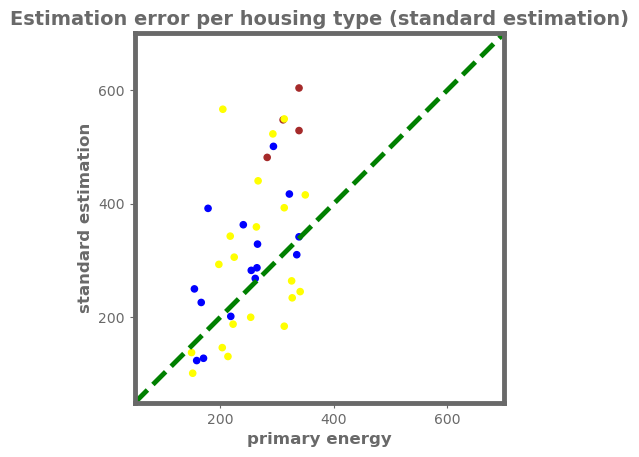

In [110]:
colors = {'Wood fuel-Standard boiler': 'brown', 'Electricity-Performance boiler': 'blue','Natural gas-Standard boiler': 'yellow', 'Natural gas-Performance boiler': 'yellow' }
scatter = buildings.plot.scatter(x = 'primary energy', y = 'primary_energy_estimated', xlim=(50, 700), ylim=(50,700), c=buildings.index.get_level_values('Heating system').map(colors), fontsize=10)
scatter.set_title('Estimation error per housing type (standard estimation)', fontsize=14)
scatter.set_xlabel('primary energy', fontsize=12)
scatter.set_ylabel('standard estimation', fontsize=12)
scatter.axis('scaled')
scatter.set(xlim=(50, 700), ylim=(50,700))
scatter = scatter.plot([0, 1], [0, 1], transform=scatter.transAxes, ls='--',  c='green' )

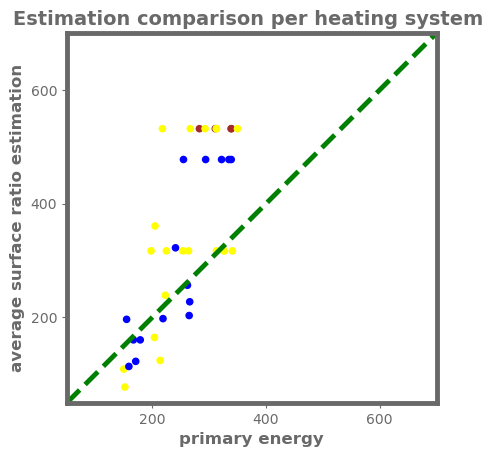

In [93]:
surface_check =  buildings.copy()
surface_check['energy_surface_estimation'] = energy_epc_surface['primary_energy_estimated']
colors = {'Wood fuel-Standard boiler': 'brown', 'Electricity-Performance boiler': 'blue','Natural gas-Standard boiler': 'yellow', 'Natural gas-Performance boiler': 'yellow' }
scatter =  surface_check.plot.scatter(x = 'primary energy', y = 'energy_surface_estimation', xlim=(50, 700), ylim=(50,700), c=buildings.index.get_level_values('Heating system').map(colors), fontsize=10)
scatter.set_title('Estimation comparison per heating system ', fontsize=14)
scatter.set_xlabel('primary energy', fontsize=12)
scatter.set_ylabel('average surface ratio estimation', fontsize=12)
scatter.axis('scaled')
scatter.set(xlim=(50, 700), ylim=(50,700))
scatter = scatter.plot([0, 1], [0, 1], transform=scatter.transAxes, ls='--',  c='green' )

In [98]:
estimations = buildings.copy()
estimations['av_surface_estimation'] = energy_epc_surface['primary_energy_estimated']
estimations.loc[:, ('construction period','Ratio_surface_Wall', 'Ratio_surface_Floor', 'Ratio_surface_Roof', 'Ratio_surface_Window' ,'primary energy', 'primary_energy_estimated', 'primary_energy_weighted','av_surface_estimation', 'estimation_error', 'weighted_estimation_error')]

,,,construction period,Ratio_surface_Wall,Ratio_surface_Floor,Ratio_surface_Roof,Ratio_surface_Window,primary energy,primary_energy_estimated,primary_energy_weighted,av_surface_estimation,estimation_error,weighted_estimation_error
Class,Housing type,Heating system,,,,,,,,,,,
MI-1,Single-family,Wood fuel-Standard boiler,Avant 1915,1.76,0.50,0.50,0.15,311,547.496148,576.681337,531.940213,236.496148,265.681337
MI-2,Single-family,Wood fuel-Standard boiler,Avant 1915,1.33,0.50,0.85,0.13,339,528.602497,549.000267,531.940213,189.602497,210.000267
MI-3,Single-family,Wood fuel-Standard boiler,Avant 1915,0.87,0.89,1.61,0.09,339,603.496288,628.667056,531.940213,264.496288,289.667056
MI-4,Single-family,Wood fuel-Standard boiler,Avant 1915,1.25,0.67,0.67,0.13,283,481.437033,510.008683,531.940213,198.437033,227.008683
MI-5,Single-family,Natural gas-Standard boiler,1915-1945,1.45,0.51,0.80,0.18,313,549.106280,583.085008,531.940213,236.106280,270.085008
MI-6,Single-family,Natural gas-Standard boiler,1915-1945,1.06,0.35,0.55,0.24,350,415.477210,441.213741,531.940213,65.477210,91.213741
MI-7,Single-family,Natural gas-Standard boiler,1915-1945,1.02,0.50,0.50,0.15,313,392.908546,414.916863,531.940213,79.908546,101.916863
MI-8,Single-family,Natural gas-Standard boiler,1946-1968,1.55,0.55,0.55,0.21,293,522.773928,543.428556,531.940213,229.773928,250.428556
MI-9,Single-family,Natural gas-Standard boiler,1946-1968,1.22,0.50,0.50,0.20,267,440.233061,446.598514,531.940213,173.233061,179.598514


### Discussion
- Wood fueled, Single-family, before 1915 built dwellings are the most over-estimated annual energy need by all methods.
- LC3 to LC4 the change to electricity for 1915 built multi-family buildings decreases energy need, while our estimations increases a lot. U-values doesn't change since the construction period are the same. What changes in our estimation is the efficiency and the surface ratio. When we look at the av_surface_estimation, for which the ratio surface remain the same, the estimation still increase instead of decreasing. I conclude that it's the efficency parameter which gives this error. Our simple weighting doesn't solve the issue.

In [43]:
energy_epc_vent.to_csv('output/building_stock_profeel_vent.csv')
energy_epc_novent.to_csv('output/building_stock_profeel_novent.csv')